**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


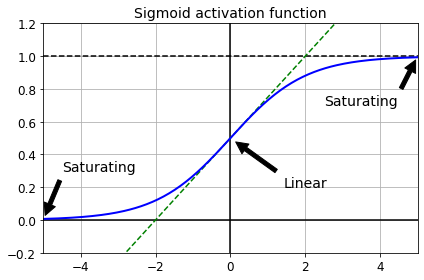

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


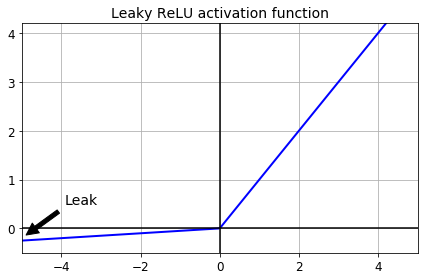

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 41us/sample - loss: 1.2810 - accuracy: 0.6205 - val_loss: 0.8869 - val_accuracy: 0.7160
Epoch 2/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.7952 - accuracy: 0.7369 - val_loss: 0.7132 - val_accuracy: 0.7626
Epoch 3/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6817 - accuracy: 0.7726 - val_loss: 0.6385 - val_accuracy: 0.7894
Epoch 4/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6219 - accuracy: 0.7942 - val_loss: 0.5931 - val_accuracy: 0.8016
Epoch 5/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.5830 - accuracy: 0.8074 - val_loss: 0.5607 - val_accuracy: 0.8170
Epoch 6/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.5552 - accuracy: 0.8172 - val_loss: 0.5355 - val_accuracy: 0.8238
Epoch 7/10
55000/55000 [==============================] -

Now let's try PReLU:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 47us/sample - loss: 1.3452 - accuracy: 0.6203 - val_loss: 0.9241 - val_accuracy: 0.7170
Epoch 2/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.8196 - accuracy: 0.7364 - val_loss: 0.7314 - val_accuracy: 0.7600
Epoch 3/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.6970 - accuracy: 0.7701 - val_loss: 0.6517 - val_accuracy: 0.7880
Epoch 4/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.6333 - accuracy: 0.7914 - val_loss: 0.6032 - val_accuracy: 0.8050
Epoch 5/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.5916 - accuracy: 0.8049 - val_loss: 0.5689 - val_accuracy: 0.8162
Epoch 6/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.5619 - accuracy: 0.8143 - val_loss: 0.5416 - val_accuracy: 0.8222
Epoch 7/10
55000/55000 [==============================] -

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


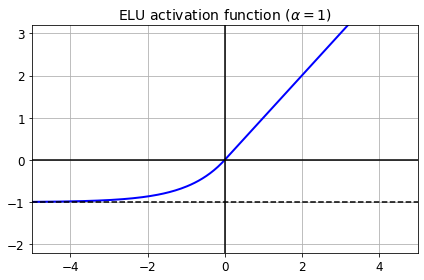

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


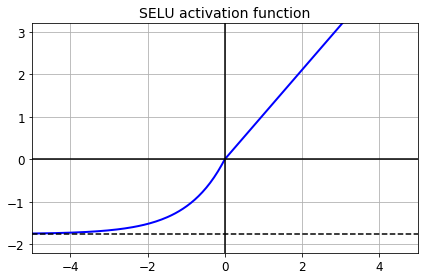

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 13s 238us/sample - loss: 1.1277 - accuracy: 0.5573 - val_loss: 0.8152 - val_accuracy: 0.6700
Epoch 2/5
55000/55000 [==============================] - 11s 198us/sample - loss: 0.6935 - accuracy: 0.7383 - val_loss: 0.5806 - val_accuracy: 0.7928
Epoch 3/5
55000/55000 [==============================] - 11s 196us/sample - loss: 0.5871 - accuracy: 0.7865 - val_loss: 0.6876 - val_accuracy: 0.7462
Epoch 4/5
55000/55000 [==============================] - 11s 199us/sample - loss: 0.5281 - accuracy: 0.8134 - val_loss: 0.5236 - val_accuracy: 0.8230
Epoch 5/5
55000/55000 [==============================] - 11s 201us/sample - loss: 0.4824 - accuracy: 0.8327 - val_loss: 0.5201 - val_accuracy: 0.8312


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 12s 213us/sample - loss: 1.7518 - accuracy: 0.2797 - val_loss: 1.2328 - val_accuracy: 0.4720
Epoch 2/5
55000/55000 [==============================] - 10s 177us/sample - loss: 1.1922 - accuracy: 0.4982 - val_loss: 1.0247 - val_accuracy: 0.5354
Epoch 3/5
55000/55000 [==============================] - 10s 178us/sample - loss: 0.9390 - accuracy: 0.6180 - val_loss: 1.0809 - val_accuracy: 0.5118
Epoch 4/5
55000/55000 [==============================] - 10s 178us/sample - loss: 0.7787 - accuracy: 0.6937 - val_loss: 0.7067 - val_accuracy: 0.7344
Epoch 5/5
55000/55000 [==============================] - 10s 180us/sample - loss: 0.7465 - accuracy: 0.7122 - val_loss: 0.9720 - val_accuracy: 0.5702


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.8760 - accuracy: 0.7122 - val_loss: 0.5509 - val_accuracy: 0.8224
Epoch 2/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.5737 - accuracy: 0.8039 - val_loss: 0.4723 - val_accuracy: 0.8460
Epoch 3/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.5143 - accuracy: 0.8231 - val_loss: 0.4376 - val_accuracy: 0.8570
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4826 - accuracy: 0.8333 - val_loss: 0.4135 - val_accuracy: 0.8638
Epoch 5/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4571 - accuracy: 0.8415 - val_loss: 0.3990 - val_accuracy: 0.8654
Epoch 6/10
55000/55000 [==============================] - 3s 53us/sample - loss: 0.4432 - accuracy: 0.8456 - val_loss: 0.3870 - val_accuracy: 0.8710
Epoch 7/10
55000/55000 [==============================] -

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.8656 - accuracy: 0.7094 - val_loss: 0.5650 - val_accuracy: 0.8098
Epoch 2/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5766 - accuracy: 0.8018 - val_loss: 0.4834 - val_accuracy: 0.8358
Epoch 3/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.5184 - accuracy: 0.8216 - val_loss: 0.4461 - val_accuracy: 0.8470
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4852 - accuracy: 0.8314 - val_loss: 0.4226 - val_accuracy: 0.8558
Epoch 5/10
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4579 - accuracy: 0.8399 - val_loss: 0.4086 - val_accuracy: 0.8604
Epoch 6/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4406 - accuracy: 0.8457 - val_loss: 0.3974 - val_accuracy: 0.8640
Epoch 7/10
55000/55000 [==============================] -

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 2s 49us/sample - loss: 0.5902 - accuracy: 0.8131 - val_loss: 0.3784 - val_accuracy: 0.8692
Epoch 2/20
43986/43986 [==============================] - 2s 43us/sample - loss: 0.3517 - accuracy: 0.8784 - val_loss: 0.3369 - val_accuracy: 0.8832
Epoch 3/20
43986/43986 [==============================] - 2s 43us/sample - loss: 0.3163 - accuracy: 0.8896 - val_loss: 0.3017 - val_accuracy: 0.8959
Epoch 4/20
43986/43986 [==============================] - 2s 43us/sample - loss: 0.2969 - accuracy: 0.8972 - val_loss: 0.2912 - val_accuracy: 0.9028
Epoch 5/20
43986/43986 [==============================] - 2s 45us/sample - loss: 0.2831 - accuracy: 0.9027 - val_loss: 0.2816 - val_accuracy: 0.9018
Epoch 6/20
43986/43986 [==============================] - 2s 44us/sample - loss: 0.2725 - accuracy: 0.9066 - val_loss: 0.2737 - val_accuracy: 0.9071
Epoch 7/20
43986/43986 [==============================] -

In [55]:
model_A.save("my_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.9509 - accuracy: 0.4800 - val_loss: 0.6533 - val_accuracy: 0.5568
Epoch 2/20
200/200 [==============================] - 0s 202us/sample - loss: 0.5837 - accuracy: 0.7100 - val_loss: 0.4825 - val_accuracy: 0.8479
Epoch 3/20
200/200 [==============================] - 0s 206us/sample - loss: 0.4527 - accuracy: 0.8750 - val_loss: 0.4097 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 219us/sample - loss: 0.3869 - accuracy: 0.9050 - val_loss: 0.3630 - val_accuracy: 0.9209
Epoch 5/20
200/200 [==============================] - 0s 224us/sample - loss: 0.3404 - accuracy: 0.9300 - val_loss: 0.3302 - val_accuracy: 0.9280
Epoch 6/20
200/200 [==============================] - 0s 225us/sample - loss: 0.3073 - accuracy: 0.9350 - val_loss: 0.3026 - val_accuracy: 0.9381
Epoch 7/20
200/200 [==============================] - 0s 228us/sample - loss: 0.

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [60]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 0.5619 - accuracy: 0.6650 - val_loss: 0.5669 - val_accuracy: 0.6531
Epoch 2/4
200/200 [==============================] - 0s 208us/sample - loss: 0.5249 - accuracy: 0.7200 - val_loss: 0.5337 - val_accuracy: 0.6957
Epoch 3/4
200/200 [==============================] - 0s 200us/sample - loss: 0.4923 - accuracy: 0.7400 - val_loss: 0.5039 - val_accuracy: 0.7211
Epoch 4/4
200/200 [==============================] - 0s 214us/sample - loss: 0.4630 - accuracy: 0.7550 - val_loss: 0.4773 - val_accuracy: 0.7383
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 2ms/sample - loss: 0.3864 - accuracy: 0.8200 - val_loss: 0.3357 - val_accuracy: 0.8661
Epoch 2/16
200/200 [==============================] - 0s 207us/sample - loss: 0.2701 - accuracy: 0.9350 - val_loss: 0.2608 - val_accuracy: 0.9249
Epoch 3/16
200/200 [====================

So, what's the final verdict?

In [64]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 28us/sample - loss: 0.1426 - accuracy: 0.9695


[0.14263125681877137, 0.9695]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 25us/sample - loss: 0.0697 - accuracy: 0.9925


[0.06966363421082497, 0.9925]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [66]:
(100 - 96.95) / (100 - 99.25)

3.933333333333337

# Faster Optimizers

## Momentum optimization

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [69]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [70]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [72]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [73]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [74]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [76]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 2s 45us/sample - loss: 0.4842 - accuracy: 0.8319 - val_loss: 0.4167 - val_accuracy: 0.8572
Epoch 2/25
55000/55000 [==============================] - 2s 41us/sample - loss: 0.3789 - accuracy: 0.8646 - val_loss: 0.3781 - val_accuracy: 0.8678
Epoch 3/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3461 - accuracy: 0.8768 - val_loss: 0.3690 - val_accuracy: 0.8706
Epoch 4/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3252 - accuracy: 0.8836 - val_loss: 0.3532 - val_accuracy: 0.8770
Epoch 5/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3091 - accuracy: 0.8896 - val_loss: 0.3454 - val_accuracy: 0.8814
Epoch 6/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.2970 - accuracy: 0.8938 - val_loss: 0.3431 - val_accuracy: 0.8798
Epoch 7/25
55000/55000 [==============================] -

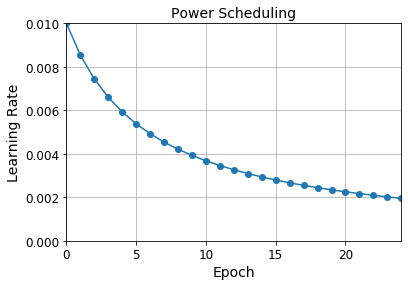

In [77]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [78]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [79]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [81]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 99us/sample - loss: 0.8503 - accuracy: 0.7562 - val_loss: 0.7115 - val_accuracy: 0.7578
Epoch 2/25
55000/55000 [==============================] - 5s 95us/sample - loss: 0.7107 - accuracy: 0.7861 - val_loss: 0.7508 - val_accuracy: 0.7642
Epoch 3/25
55000/55000 [==============================] - 5s 88us/sample - loss: 0.6246 - accuracy: 0.8084 - val_loss: 0.6204 - val_accuracy: 0.7968
Epoch 4/25
55000/55000 [==============================] - 5s 91us/sample - loss: 0.5598 - accuracy: 0.8278 - val_loss: 0.6224 - val_accuracy: 0.8446
Epoch 5/25
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5242 - accuracy: 0.8365 - val_loss: 0.5441 - val_accuracy: 0.8338
Epoch 6/25
55000/55000 [==============================] - 5s 84us/sample - loss: 0.4533 - accuracy: 0.8541 - val_loss: 0.5239 - val_accuracy: 0.8466
Epoch 7/25
55000/55000 [==============================] -

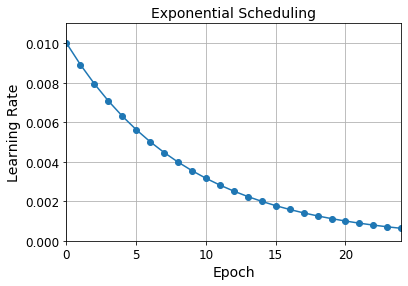

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [83]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [84]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 106us/sample - loss: 0.7950 - accuracy: 0.7678 - val_loss: 0.7626 - val_accuracy: 0.7202
Epoch 2/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.6238 - accuracy: 0.8097 - val_loss: 0.5616 - val_accuracy: 0.8304
Epoch 3/25
55000/55000 [==============================] - 6s 108us/sample - loss: 0.5716 - accuracy: 0.8217 - val_loss: 0.6381 - val_accuracy: 0.8120
Epoch 4/25
55000/55000 [==============================] - 6s 106us/sample - loss: 0.5121 - accuracy: 0.8391 - val_loss: 0.6855 - val_accuracy: 0.8114
Epoch 5/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4785 - accuracy: 0.8495 - val_loss: 0.5208 - val_accuracy: 0.8556
Epoch 6/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.4188 - accuracy: 0.8659 - val_loss: 0.5239 - val_accuracy: 0.8542
Epoch 7/25
55000/55000 [===========================

In [85]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

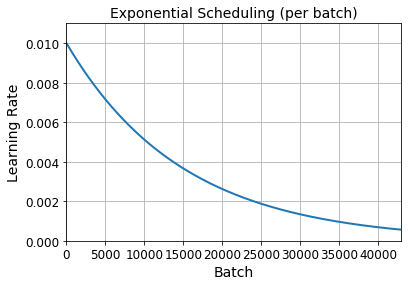

In [86]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [87]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [88]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 105us/sample - loss: 0.8429 - accuracy: 0.7634 - val_loss: 0.9667 - val_accuracy: 0.6432
Epoch 2/25
55000/55000 [==============================] - 5s 97us/sample - loss: 0.8500 - accuracy: 0.7677 - val_loss: 0.6907 - val_accuracy: 0.8070
Epoch 3/25
55000/55000 [==============================] - 5s 97us/sample - loss: 0.7974 - accuracy: 0.7831 - val_loss: 0.8228 - val_accuracy: 0.7608
Epoch 4/25
55000/55000 [==============================] - 5s 98us/sample - loss: 0.8931 - accuracy: 0.7344 - val_loss: 1.1275 - val_accuracy: 0.7434
Epoch 5/25
55000/55000 [==============================] - 6s 102us/sample - loss: 0.9565 - accuracy: 0.7025 - val_loss: 0.8436 - val_accuracy: 0.7664
Epoch 6/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.6047 - accuracy: 0.7910 - val_loss: 0.7323 - val_accuracy: 0.8054
Epoch 7/25
55000/55000 [==============================

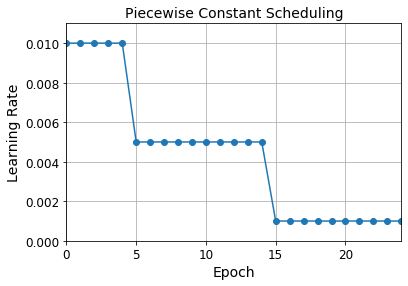

In [90]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 2s 44us/sample - loss: 0.5950 - accuracy: 0.8063 - val_loss: 0.5177 - val_accuracy: 0.8426
Epoch 2/25
55000/55000 [==============================] - 2s 39us/sample - loss: 0.5091 - accuracy: 0.8373 - val_loss: 0.4850 - val_accuracy: 0.8534
Epoch 3/25
55000/55000 [==============================] - 2s 41us/sample - loss: 0.5029 - accuracy: 0.8437 - val_loss: 0.4905 - val_accuracy: 0.8400
Epoch 4/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.5372 - accuracy: 0.8436 - val_loss: 0.6500 - val_accuracy: 0.8378
Epoch 5/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.5189 - accuracy: 0.8497 - val_loss: 0.4873 - val_accuracy: 0.8618
Epoch 6/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.5190 - accuracy: 0.8515 - val_loss: 0.8216 - val_accuracy: 0.8420
Epoch 7/25
55000/55000 [==============================] -

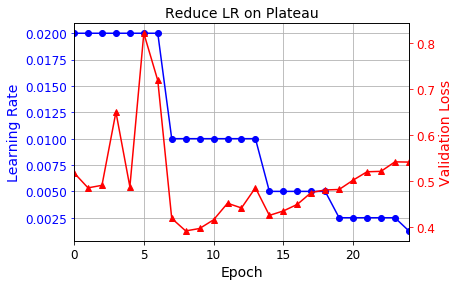

In [93]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4872 - accuracy: 0.8296 - val_loss: 0.4141 - val_accuracy: 0.8548
Epoch 2/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3829 - accuracy: 0.8643 - val_loss: 0.3773 - val_accuracy: 0.8704
Epoch 3/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3495 - accuracy: 0.8763 - val_loss: 0.3696 - val_accuracy: 0.8730
Epoch 4/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3274 - accuracy: 0.8831 - val_loss: 0.3545 - val_accuracy: 0.8760
Epoch 5/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3102 - accuracy: 0.8899 - val_loss: 0.3460 - val_accuracy: 0.8784
Epoch 6/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.2971 - accuracy: 0.8945 - val_loss: 0.3415 - val_accuracy: 0.8796
Epoch 7/25
55000/55000 [==============================] -

For piecewise constant scheduling, try this:

In [95]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [96]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 1s 22us/sample - loss: nan - accuracy: 0.3879


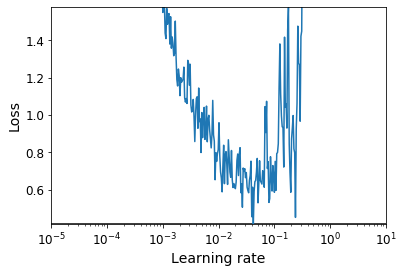

In [98]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [99]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.6576 - accuracy: 0.7743 - val_loss: 0.4901 - val_accuracy: 0.8300
Epoch 2/25
55000/55000 [==============================] - 1s 18us/sample - loss: 0.4587 - accuracy: 0.8387 - val_loss: 0.4316 - val_accuracy: 0.8490
Epoch 3/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.4119 - accuracy: 0.8560 - val_loss: 0.4117 - val_accuracy: 0.8580
Epoch 4/25
55000/55000 [==============================] - 1s 23us/sample - loss: 0.3842 - accuracy: 0.8657 - val_loss: 0.3920 - val_accuracy: 0.8638
Epoch 5/25
55000/55000 [==============================] - 1s 21us/sample - loss: 0.3636 - accuracy: 0.8708 - val_loss: 0.3739 - val_accuracy: 0.8710
Epoch 6/25
55000/55000 [==============================] - 1s 21us/sample - loss: 0.3460 - accuracy: 0.8767 - val_loss: 0.3742 - val_accuracy: 0.8690
Epoch 7/25
55000/55000 [==============================] -

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [101]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 130us/sample - loss: 1.5735 - accuracy: 0.8126 - val_loss: 0.7327 - val_accuracy: 0.8222
Epoch 2/2
55000/55000 [==============================] - 6s 115us/sample - loss: 0.7186 - accuracy: 0.8260 - val_loss: 0.6929 - val_accuracy: 0.8338


In [103]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 133us/sample - loss: 1.6006 - accuracy: 0.8129 - val_loss: 0.7374 - val_accuracy: 0.8236
Epoch 2/2
55000/55000 [==============================] - 7s 128us/sample - loss: 0.7179 - accuracy: 0.8265 - val_loss: 0.6905 - val_accuracy: 0.8356


## Dropout

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 139us/sample - loss: 0.5856 - accuracy: 0.7992 - val_loss: 0.3908 - val_accuracy: 0.8570
Epoch 2/2
55000/55000 [==============================] - 6s 117us/sample - loss: 0.4260 - accuracy: 0.8443 - val_loss: 0.3389 - val_accuracy: 0.8730


## Alpha Dropout

In [105]:
tf.random.set_seed(42)
np.random.seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 55us/sample - loss: 0.6616 - accuracy: 0.7616 - val_loss: 0.6682 - val_accuracy: 0.8258
Epoch 2/20
55000/55000 [==============================] - 3s 49us/sample - loss: 0.5526 - accuracy: 0.7969 - val_loss: 0.5835 - val_accuracy: 0.8382
Epoch 3/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5259 - accuracy: 0.8060 - val_loss: 0.5312 - val_accuracy: 0.8512
Epoch 4/20
55000/55000 [==============================] - 3s 49us/sample - loss: 0.5076 - accuracy: 0.8111 - val_loss: 0.4969 - val_accuracy: 0.8606
Epoch 5/20
55000/55000 [==============================] - 3s 47us/sample - loss: 0.4929 - accuracy: 0.8175 - val_loss: 0.4875 - val_accuracy: 0.8610
Epoch 6/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4844 - accuracy: 0.8190 - val_loss: 0.5141 - val_accuracy: 0.8552
Epoch 7/20
55000/55000 [==============================] -

In [107]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 25us/sample - loss: 0.4736 - accuracy: 0.8648


[0.47358015085458754, 0.8648]

In [108]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 1s 22us/sample - loss: 0.3532 - accuracy: 0.8859


[0.35321958436965945, 0.8859091]

In [109]:
history = model.fit(X_train_scaled, y_train)

Train on 55000 samples
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4186 - accuracy: 0.8451


## MC Dropout

In [110]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [112]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [113]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.17, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.01, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.03, 0.05, 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.04, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.61, 0.  , 0.01, 0.  , 0.38]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.04, 0.  , 0.63]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.06, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.  , 0.09, 0.  , 0

In [114]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.06, 0.  , 0.81]],
      dtype=float32)

In [115]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.01, 0.08, 0.01, 0.21]],
      dtype=float32)

In [116]:
y_pred = np.argmax(y_proba, axis=1)

In [117]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8606

In [118]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [119]:
tf.random.set_seed(42)
np.random.seed(42)

In [120]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [121]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [122]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [123]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [124]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.07, 0.01, 0.79]],
      dtype=float32)

## Max norm

In [125]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 6s 114us/sample - loss: 0.4734 - accuracy: 0.8364 - val_loss: 0.3999 - val_accuracy: 0.8614
Epoch 2/2
55000/55000 [==============================] - 6s 100us/sample - loss: 0.3583 - accuracy: 0.8685 - val_loss: 0.3494 - val_accuracy: 0.8746


# Exercises

## 1. to 7.

See appendix A.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [127]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [128]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [129]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [130]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [131]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [132]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [133]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 9s 208us/sample - loss: 4.0892 - accuracy: 0.1672 - val_loss: 2.1601 - val_accuracy: 0.2020
Epoch 2/100
45000/45000 [==============================] - 8s 175us/sample - loss: 2.0558 - accuracy: 0.2469 - val_loss: 1.9845 - val_accuracy: 0.2808
Epoch 3/100
45000/45000 [==============================] - 7s 161us/sample - loss: 1.9306 - accuracy: 0.2942 - val_loss: 1.9089 - val_accuracy: 0.2934
Epoch 4/100
45000/45000 [==============================] - 7s 157us/sample - loss: 1.8437 - accuracy: 0.3332 - val_loss: 1.7957 - val_accuracy: 0.3510
Epoch 5/100
45000/45000 [==============================] - 7s 162us/sample - loss: 1.7829 - accuracy: 0.3560 - val_loss: 1.7779 - val_accuracy: 0.3582
Epoch 6/100
45000/45000 [==============================] - 7s 154us/sample - loss: 1.7374 - accuracy: 0.3702 - val_loss: 1.8059 - val_accuracy: 0.3540
Epoch 7/100
45000/45000 [====================

In [134]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

5000/5000 [==============================] - 0s 65us/sample - loss: 1.5099 - accuracy: 0.4736


[1.5099372177124024, 0.4736]

The model with the lowest validation loss gets about 47% accuracy on the validation set. It took 39 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [135]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 21s 466us/sample - loss: 1.8365 - accuracy: 0.3390 - val_loss: 1.6330 - val_accuracy: 0.4174
Epoch 2/100
45000/45000 [==============================] - 16s 352us/sample - loss: 1.6623 - accuracy: 0.4063 - val_loss: 1.5967 - val_accuracy: 0.4204
Epoch 3/100
45000/45000 [==============================] - 16s 355us/sample - loss: 1.5946 - accuracy: 0.4314 - val_loss: 1.5225 - val_accuracy: 0.4602
Epoch 4/100
45000/45000 [==============================] - 17s 367us/sample - loss: 1.5417 - accuracy: 0.4551 - val_loss: 1.4680 - val_accuracy: 0.4756
Epoch 5/100
45000/45000 [==============================] - 17s 367us/sample - loss: 1.5013 - accuracy: 0.4678 - val_loss: 1.4378 - val_accuracy: 0.4862
Epoch 6/100
45000/45000 [==============================] - 16s 361us/sample - loss: 1.4637 - accuracy: 0.4797 - val_loss: 1.4221 - val_accuracy: 0.4982
Epoch 7/100
45000/45000 [==============

[1.305354326057434, 0.5506]

* *Is the model converging faster than before?* Much faster! The previous model took 39 epochs to reach the lowest validation loss, while the new model with BN took 18 epochs. That's more than twice as fast as the previous model. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 55% accuracy instead of 47%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged twice as fast, each epoch took about 16s instead of 10s, because of the extra computations required by the BN layers. So overall, although the number of epochs was reduced by 50%, the training time (wall time) was shortened by 30%. Which is still pretty significant!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [136]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 12s 268us/sample - loss: 1.9310 - accuracy: 0.3055 - val_loss: 1.7814 - val_accuracy: 0.3566
Epoch 2/100
45000/45000 [==============================] - 10s 216us/sample - loss: 1.7077 - accuracy: 0.3935 - val_loss: 1.9245 - val_accuracy: 0.3654
Epoch 3/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.6116 - accuracy: 0.4314 - val_loss: 1.6612 - val_accuracy: 0.4316
Epoch 4/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.5385 - accuracy: 0.4590 - val_loss: 1.5879 - val_accuracy: 0.4414
Epoch 5/100
45000/45000 [==============================] - 11s 234us/sample - loss: 1.4911 - accuracy: 0.4746 - val_loss: 1.5470 - val_accuracy: 0.4626
Epoch 6/100
45000/45000 [==============================] - 9s 205us/sample - loss: 1.4419 - accuracy: 0.4964 - val_loss: 1.5535 - val_accuracy: 0.4662
Epoch 7/100
45000/45000 [===============

[1.462584439086914, 0.514]

In [137]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

5000/5000 [==============================] - 0s 74us/sample - loss: 1.4626 - accuracy: 0.5140


[1.462584439086914, 0.514]

We get 51.4% accuracy, which is better than the original model, but not quite as good as the model using batch normalization. Moreover, it took 13 epochs to reach the best model, which is much faster than both the original model and the BN model, plus each epoch took only 10 seconds, just like the original model. So it's by far the fastest model to train (both in terms of epochs and wall time).

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [138]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 12s 263us/sample - loss: 1.8763 - accuracy: 0.3330 - val_loss: 1.7595 - val_accuracy: 0.3668
Epoch 2/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.6527 - accuracy: 0.4148 - val_loss: 1.7666 - val_accuracy: 0.3808
Epoch 3/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.5682 - accuracy: 0.4439 - val_loss: 1.6393 - val_accuracy: 0.4490
Epoch 4/100
45000/45000 [==============================] - 10s 211us/sample - loss: 1.5030 - accuracy: 0.4698 - val_loss: 1.6028 - val_accuracy: 0.4466
Epoch 5/100
45000/45000 [==============================] - 9s 209us/sample - loss: 1.4430 - accuracy: 0.4913 - val_loss: 1.5394 - val_accuracy: 0.4562
Epoch 6/100
45000/45000 [==============================] - 10s 215us/sample - loss: 1.4005 - accuracy: 0.5084 - val_loss: 1.5408 - val_accuracy: 0.4818
Epoch 7/100
45000/45000 [===============

[1.4974345008850098, 0.5082]

The model reaches 50.8% accuracy on the validation set. That's very slightly worse than without dropout (51.4%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [139]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [140]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [141]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [142]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.5094

We only get virtually no accuracy improvement in this case (from 50.8% to 50.9%).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [143]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Train on 45000 samples
45000/45000 [==============================] - 3s 60us/sample - loss: nan - accuracy: 0.1403


[1e-05, 9.999868, 2.0895472, 3.482099260602679]

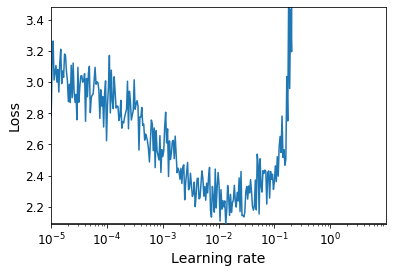

In [144]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [145]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [146]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 3s 69us/sample - loss: 2.0504 - accuracy: 0.2823 - val_loss: 1.7711 - val_accuracy: 0.3706
Epoch 2/15
45000/45000 [==============================] - 3s 57us/sample - loss: 1.7626 - accuracy: 0.3766 - val_loss: 1.7751 - val_accuracy: 0.3844
Epoch 3/15
45000/45000 [==============================] - 3s 59us/sample - loss: 1.6264 - accuracy: 0.4272 - val_loss: 1.6774 - val_accuracy: 0.4216
Epoch 4/15
45000/45000 [==============================] - 3s 57us/sample - loss: 1.5527 - accuracy: 0.4474 - val_loss: 1.6633 - val_accuracy: 0.4316
Epoch 5/15
45000/45000 [==============================] - 3s 59us/sample - loss: 1.4997 - accuracy: 0.4701 - val_loss: 1.5909 - val_accuracy: 0.4540
Epoch 6/15
45000/45000 [==============================] - 3s 60us/sample - loss: 1.4564 - accuracy: 0.4841 - val_loss: 1.5982 - val_accuracy: 0.4624
Epoch 7/15
45000/45000 [==============================] -

One cycle allowed us to train the model in just 15 epochs, each taking only 3 seconds (thanks to the larger batch size). This is over 3 times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.8% to 52.8%). The batch normalized model reaches a slightly better performance, but it's much slower to train.